---

# REACTOR PWR
__*Daniel Oliva Rodríguez*__

---

Para realizar una simulación en __*OpenMC*__ es necesario crear 3 archivos:
-  *materials.xml*: definición de los materiales presentes en el problema.
-  *geometry.xml*: definición de la geometría.
-  *settings.xml*: definición de la configuración de la simulación.

Siendo opcioneles la creación de otros 2:
-  *tallies.xml*: definición de los parámetros que se quieren medir durante la simulación.
-  *plots.xml*: definición de la representación gráfica de la geometría.

---

**ruta del archivo jupyter: _"raiz/simulaciones/pwr"_**

Ruta para guardar los archivos generados:

In [1]:
ruta = './build_10'

---

Importación de los módulos necesarios para la simulación:

In [2]:
import openmc
import openmc.deplete
import math
import os
import numpy as np
from matplotlib import pyplot
from PIL import Image as Image_ppm # Para convertir la imagen .ppm en .jpg
from IPython.display import Image, display # Para mostrar la imagen .jpg

In [3]:
os.mkdir(ruta)

In [4]:
os.mkdir(ruta + "/imagenes")

## MATERIALS

**Paso 1: Definición de Materiales** <br>
En este primer apartado __*materials*__ se definen los materiales que se van a emplear en la simulación (combustible, revestimiento, moderador, refrigerante, etc.).

Todas las definiciones de materiales tienen la misma morfología:
-  Se inicializa el material con __*openmc.Material(ID, "nombre")*__.
-  Se añade un elemento (con sus isótopos naturales) mediante __*add_element('símbolo', fracción, tipo_fracción)*__.
   -  La fracción puede ser atómica (*ao*) o en masa (*wo*). Si no se especifica, se toma por defecto *ao*.
   -  Se puede usar __*add_nuclide('símbolo', fracción, tipo_fracción)*__ para especificar un solo isótopo del elemento.
   -  En el caso del uranio, se puede establecer el enriquecimiento en U235 mediante un ajuste adicional: __*enrichment=4.2*__.
-  La densidad total del material se especifica mediante __*set_density('unidades', densidad)*__.

Definición de los materiales del **combustible**:<br>

Densidad nominal del combustible (95,5% de la teórica)

In [5]:
densidad = 0.955 * 10.97

Combustible de bajo enriquecimiento (*low enrichment*) de **2.35%**:

In [6]:
# Inicialización del material
fuel_uo2_le = openmc.Material(1, "uo2_le")

# Se agrega uranio con el enriquecimiento y la fracción de O del UO2
fuel_uo2_le.add_element('U', 1.0, enrichment=2.35)
fuel_uo2_le.add_element('O', 2.0)

# Se define el valor de la densidad del combustible
fuel_uo2_le.set_density('g/cm3', densidad)

Combustible de medio enriquecimiento (*mid enrichment*) de **3.4%**:

In [7]:
# Inicialización del material
fuel_uo2_me = openmc.Material(2, "uo2_me")

# Se agrega uranio con el enriquecimiento y la fracción de O del UO2
fuel_uo2_me.add_element('U', 1.0, enrichment=3.4)
fuel_uo2_me.add_element('O', 2.0)

# Se define el valor de la densidad del combustible
fuel_uo2_me.set_density('g/cm3', densidad)

Combustible de alto enriquecimiento (*high enrichment*) de **4.45%**:

In [8]:
# Inicialización del material
fuel_uo2_he = openmc.Material(3, "uo2_he")

# Se agrega uranio con el enriquecimiento y la fracción de O del UO2
fuel_uo2_he.add_element('U', 1.0, enrichment=4.45)
fuel_uo2_he.add_element('O', 2.0)

# Se define el valor de la densidad del combustible
fuel_uo2_he.set_density('g/cm3', densidad)

Gadolinio como veneno consumible

In [9]:
Gd2O3 = openmc.Material(4, "Gd2O3")
Gd2O3.add_element('Gd', 2.0)
Gd2O3.add_element('O', 3.0)
Gd2O3.set_density('g/cm3', 7.41)

Combustible de bajo, medio y alto enriquecimiento con gadolinio:

In [10]:
fuel_uo2_lbp = openmc.Material.mix_materials([Gd2O3, fuel_uo2_le], [0.05, 0.95], 'wo') # Material 5
fuel_uo2_mbp = openmc.Material.mix_materials([Gd2O3, fuel_uo2_me], [0.05, 0.95], 'wo') # Material 6
fuel_uo2_hbp = openmc.Material.mix_materials([Gd2O3, fuel_uo2_he], [0.02, 0.98], 'wo') # Material 7

Definición de los materiales del **revestimiento** del combustible (__*Zircaloy - 4*__):

In [11]:
# Inicialización del material
clad = openmc.Material(9, "cladding")

# Se agrega zirconio al material
clad.add_element('Zr', 0.9756, 'wo')
clad.add_element('Sn', 0.17, 'wo')
clad.add_element('Cr', 0.37, 'wo')
clad.add_element('Fe', 0.37, 'wo')

# Se define la densidad del material del revestimiento
clad.set_density('g/cm3', 6.56)  

Definición de los materiales del **refrigerante**:

In [12]:
water = openmc.Material(10, name='Agua borada')
water.set_density('g/cm3', 1.0)
water.add_element('H', 2.0)
water.add_element('O', 1.0)
# water.add_element('B', 5e-4)
water.add_element('B', 3340.625 * 1e-6) # openmc.search_for_keff
water.add_s_alpha_beta('c_H_in_H2O')

Para el caso del agua o el grafito, es necesario especificar la *Thermal Scattering Data*.

**Dispersión Térmica S(α,β)**

En simulaciones de transporte de neutrones, es importante considerar cómo los neutrones interactúan con los núcleos de los átomos en los materiales.
A bajas energías (energías térmicas), estas interacciones son significativamente influenciadas por los movimientos térmicos de los núcleos en una red cristalina (sólido) o en moléculas (líquidos o gases).

-  La función **S(α,β)** describe la dispersión inelástica y la absorción de neutrones en materiales moderadores a energías térmicas.
-  α y β son parámetros adimensionales que representan la transferencia de energía y momento en la colisión entre el neutrón y el núcleo.
-  Esta función es especialmente importante para materiales moderadores como el agua, donde los neutrones pierden energía (se "moderan") y alcanzan el equilibrio térmico con el moderador.

OpenMC utiliza bibliotecas de datos nucleares que incluyen estas funciones S(α,β) para materiales comunes como el agua, grafito, berilio, etc.<br>
La línea __*water.add_s_alpha_beta('c_H_in_H2O')*__ indica a OpenMC que debe usar los datos de dispersión térmica S(α,β) para el hidrógeno en agua (H2O).

Se definen los materiales de la estructura externa al núcleo:

In [13]:
vasija = openmc.Material(11, name='Vasija del reactor')
vasija.set_density('g/cm3', 7.9)
vasija.add_nuclide('Fe54', 0.05437098, 'wo')
vasija.add_nuclide('Fe56', 0.88500663, 'wo')
vasija.add_nuclide('Fe57', 0.0208008, 'wo')
vasija.add_nuclide('Fe58', 0.00282159, 'wo')
vasija.add_nuclide('Ni58', 0.0067198, 'wo')
vasija.add_nuclide('Ni60', 0.0026776, 'wo')
vasija.add_nuclide('Mn55', 0.01, 'wo')
vasija.add_nuclide('Cr52', 0.002092475, 'wo')
vasija.add_nuclide('C0', 0.0025, 'wo')
vasija.add_nuclide('Cu63', 0.0013696, 'wo')

In [14]:
reflec_inf = openmc.Material(12, name='Reflector inferior')
reflec_inf.set_density('g/cm3', 4.32)
reflec_inf.add_nuclide('H1', 0.0095661, 'wo')
reflec_inf.add_nuclide('O16', 0.0759107, 'wo')
reflec_inf.add_nuclide('Fe54', 0.035620772088, 'wo')
reflec_inf.add_nuclide('Fe56', 0.579805982228, 'wo')
reflec_inf.add_nuclide('Fe57', 0.01362750048, 'wo')
reflec_inf.add_nuclide('Fe58', 0.001848545204, 'wo')
reflec_inf.add_nuclide('Ni58', 0.055298376566, 'wo')
reflec_inf.add_nuclide('Mn55', 0.0182870, 'wo')
reflec_inf.add_nuclide('Cr52', 0.145407678031, 'wo')
reflec_inf.add_s_alpha_beta('c_H_in_H2O')

In [15]:
reflec_sup = openmc.Material(13, name='Reflector superior')
reflec_sup.set_density('g/cm3', 4.28)
reflec_sup.add_nuclide('H1', 0.0086117, 'wo')
reflec_sup.add_nuclide('O16', 0.0683369, 'wo')
reflec_sup.add_nuclide('Fe54', 0.035953677186, 'wo')
reflec_sup.add_nuclide('Fe56', 0.585224740891, 'wo')
reflec_sup.add_nuclide('Fe57', 0.01375486056, 'wo')
reflec_sup.add_nuclide('Fe58', 0.001865821363, 'wo')
reflec_sup.add_nuclide('Ni58', 0.055815129186, 'wo')
reflec_sup.add_nuclide('Mn55', 0.0184579, 'wo')
reflec_sup.add_nuclide('Cr52', 0.146766614995, 'wo')
reflec_sup.add_s_alpha_beta('c_H_in_H2O')

In [16]:
placa_inf = openmc.Material(14, name='Placa inferior vasija')
placa_inf.set_density('g/cm3', 7.184)
placa_inf.add_nuclide('H1', 0.0011505, 'wo')
placa_inf.add_nuclide('O16', 0.0091296, 'wo')
placa_inf.add_nuclide('Fe54', 0.03855611055, 'wo')
placa_inf.add_nuclide('Fe56', 0.627585036425, 'wo')
placa_inf.add_nuclide('Fe57', 0.014750478, 'wo')
placa_inf.add_nuclide('Fe58', 0.002000875025, 'wo')
placa_inf.add_nuclide('Ni58', 0.059855207342, 'wo')
placa_inf.add_nuclide('Mn55', 0.0197940, 'wo')
placa_inf.add_nuclide('Cr52', 0.157390026871, 'wo')
placa_inf.add_s_alpha_beta('c_H_in_H2O')

In [17]:
plenum_inf = openmc.Material(15, name='Plenum inferior')
plenum_inf.set_density('g/cm3', 2.53)
plenum_inf.add_nuclide('H1', 0.0245014, 'wo')
plenum_inf.add_nuclide('O16', 0.1944274, 'wo')
plenum_inf.add_nuclide('Fe54', 0.030411411144, 'wo')
plenum_inf.add_nuclide('Fe56', 0.495012237964, 'wo')
plenum_inf.add_nuclide('Fe57', 0.01163454624, 'wo')
plenum_inf.add_nuclide('Fe58', 0.001578204652, 'wo')
plenum_inf.add_nuclide('Ni58', 0.047211231662, 'wo')
plenum_inf.add_nuclide('Mn55', 0.0156126, 'wo')
plenum_inf.add_nuclide('Cr52', 0.124142524198, 'wo')
plenum_inf.add_s_alpha_beta('c_H_in_H2O')

In [18]:
plenum_sup = openmc.Material(16, name='Plenum superior')
plenum_sup.set_density('g/cm3', 1.746)
plenum_sup.add_nuclide('H1', 0.0358870, 'wo')
plenum_sup.add_nuclide('O16', 0.2847761, 'wo')
plenum_sup.add_nuclide('Fe54', 0.02644016154, 'wo')
plenum_sup.add_nuclide('Fe56', 0.43037146399, 'wo')
plenum_sup.add_nuclide('Fe57', 0.0101152584, 'wo')
plenum_sup.add_nuclide('Fe58', 0.00137211607, 'wo')
plenum_sup.add_nuclide('Ni58', 0.04104621835, 'wo')
plenum_sup.add_nuclide('Mn55', 0.0135739, 'wo')
plenum_sup.add_nuclide('Cr52', 0.107931450781, 'wo')
plenum_sup.add_s_alpha_beta('c_H_in_H2O')

In [19]:
c_superior = openmc.Material(17, name='Cabezal superior elementos combustibles')
c_superior.set_density('g/cm3', 3.044)
c_superior.add_nuclide('H1', 0.0162913, 'wo')
c_superior.add_nuclide('O16', 0.1292776, 'wo')
c_superior.add_nuclide('Zr90', 0.43313403903, 'wo')
c_superior.add_nuclide('Zr91', 0.09549277374, 'wo')
c_superior.add_nuclide('Zr92', 0.14759527104, 'wo')
c_superior.add_nuclide('Zr94', 0.15280552077, 'wo')
c_superior.add_nuclide('Zr96', 0.02511169542, 'wo')
c_superior.add_s_alpha_beta('c_H_in_H2O')

In [20]:
c_inferior = openmc.Material(18, name='Cabezal inferior elementos combustibles')
c_inferior.set_density('g/cm3', 1.762)
c_inferior.add_nuclide('H1', 0.0292856, 'wo')
c_inferior.add_nuclide('O16', 0.2323919, 'wo')
c_inferior.add_nuclide('Zr90', 0.3741373658, 'wo')
c_inferior.add_nuclide('Zr91', 0.0824858164, 'wo')
c_inferior.add_nuclide('Zr92', 0.1274914944, 'wo')
c_inferior.add_nuclide('Zr94', 0.1319920622, 'wo')
c_inferior.add_nuclide('Zr96', 0.0216912612, 'wo')
c_inferior.add_s_alpha_beta('c_H_in_H2O')

También es posible establecer la temperatura inicial de los materiales creados mediante: <br>
Se establece la temperatura del material a 900 K: __*Material.temperature = 900*__.<br>

Por último, es necesario crear el archivo "materials.xml", que será el formato empleado por *OpenMC*.<br>
Para ello, se inicializa la clase *Materials* (que actúa como una lista de python) y se añaden todos los materiales creados: 

In [21]:
materials = openmc.Materials([fuel_uo2_le, fuel_uo2_me, fuel_uo2_he, fuel_uo2_lbp, fuel_uo2_mbp, 
                              fuel_uo2_hbp, Gd2O3, clad, water, vasija, reflec_inf, reflec_sup, 
                              placa_inf, plenum_inf, plenum_sup, c_superior, c_inferior])

Por último, se exporta a *XML*:

In [22]:
materials.export_to_xml()

In [23]:
# cat materials.xml

___

## GEOMETRY

**Paso 2: Definición de la Geometría** <br>
En este segundo apartado __*geometry*__ se define la disposción geométrica de los materiales definidos anteriormente.<br>
OpenMC representa volúmenes mediante Geometría Constructiva de Sólidos (CSG), para ello es necesario definir los siguientes elementos:<br>

-  Superficies
-  Regiones y condiciones de contorno
-  Celdas
-  Universos
-  Lattices

Primero se definen las variables especfíficas del diseño:

In [24]:
pitch = 1.26                # Pitch varillas
pitch_assembly = 21.42      # Pitch fuel assembly
combustible_d = 0.7840      # Diámetro pastilla de combustible
rev_di = 0.8001             # Diámetro interno revestimiento
rev_de = 0.8898             # Diámetro externo revestimiento
tg_de = 1.204               # Diámetro exterior tubo guía / instrumentación
tg_di = 1.124               # Diámetro interior tubo guía / instrumentación
reflector_ri = 175          # Radio interior reflector
vasija_ri = 195             # Radio interior vasija
vasija_re = 215             # Radio exterior vasija

### Superficies y condiciones de contorno

Las superficies pueden ser definidas mediante planos, cilindros o esferas.<br>
Para definir la geometría de un reactor completo se van a usar:<br>
-  Cilindros para las barras de combustible (combustible, revestimiento, etc.) y para la estructura de la vasija.
-  Planos en *Z* para definir las alturas de los distintos elementos del reactor.

In [25]:
# Superficies cilíndricas
s_fuel = openmc.ZCylinder(r=combustible_d/2, surface_id=1) #Superfice externa combustible
s_rev_int = openmc.ZCylinder(r=rev_di/2, surface_id=2) # Superficie interna revestimiento
s_rev_ext = openmc.ZCylinder(r=rev_de/2, surface_id=3) # Superficie externa revestimiento
s_tgi = openmc.ZCylinder(r=tg_di/2, surface_id=4) # Superficie interna tubo guia / instrumentación
s_tge = openmc.ZCylinder(r=tg_de/2, surface_id=5) # Superficie interna tubo guia / instrumentación S4
s_pl = openmc.ZCylinder(r=155.5, surface_id=6) # Diámetro de las placas superior e inferior del núcleo
s_ref_int = openmc.ZCylinder(r=reflector_ri, surface_id=7)  # Superficie interior reflector
s_ref_ext = openmc.ZCylinder(r=vasija_ri, surface_id=8) # Superficie exterior reflector / interior vasija
s_vasija = openmc.ZCylinder(r=vasija_re, surface_id=9, boundary_type='vacuum') # Superficie exterior vasija

# Superficies planas
s_z0 = openmc.ZPlane(z0=-229.0, surface_id=30, boundary_type='vacuum') # Límite inferior de la vasija
s_z1 = openmc.ZPlane(z0=-199.0, surface_id=31) # Límite inferior del plenum inferior
s_z2 = openmc.ZPlane(z0=-193.0, surface_id=32) # Límite inferior cabezal inferior
s_z3 = openmc.ZPlane(z0=-183.0, surface_id=33) # Límite inferior elementos combustibles
s_z4 = openmc.ZPlane(z0=183.0, surface_id=34) # Límite superior elementos combustibles
s_z5 = openmc.ZPlane(z0=203.0, surface_id=35) # Límite superior cabezal superior
s_z6 = openmc.ZPlane(z0=215.0, surface_id=36) # Límite superior plenum superior
s_z7 = openmc.ZPlane(z0=223.0, surface_id=37, boundary_type='vacuum') # Límite superior vasija

### Regiones

**Varillas de combustible:**

In [26]:
# La región de combustible se define como el espacio interior delimitado por la superficie del combustible
fuel_region = -s_fuel

# La región de gap, se define como el espacio entre la superficie externa del combustible y la superficie interna del revestimiento
gap_region = +s_fuel & -s_rev_int

# La región del revestimiento se define como el espacio interior entre las dos superficies del revestimiento (interna y externa)
clad_region = +s_rev_int & -s_rev_ext

# La región del refrigerante se define como todo el espacio exterior al radio externo del revestimiento
water_region = +s_rev_ext

**Tubos guía / instrumentación:**

In [27]:
# La región de agua interior del tubo guía se define como el espacio interior delimitado por la superficie interior
water_region_itg = -s_tgi

# La región del revestimiento del tubo guía se encuentra entre los diámetros menor y mayor del revestimiento
clad_region_tg = +s_tgi & -s_tge

# La región de agua exterior del tubo guía se define como el espacio exterior al diámetro mayor
water_region_etg = +s_tge

### Celdas y Universos

Una vez definidas las regiones, es necesario definir qué materiales las forman, eso se hace mediante celdas.<br>
Las celdas se agrupan en universos, que pueden emplearse como unidades repetitivas. Por ello, y para facilitar la construcción de la geometría, se van a crear universos para las distintas varillas de combustible (para varios enriquecimientos y composiciones) y tubos guía.

**Tubo guía**

In [28]:
tube = openmc.Universe(name='Tubo guía / instrumentación', universe_id=100)
c20 = openmc.Cell(cell_id=20, fill=water, region=water_region_itg)
c21 = openmc.Cell(cell_id=21, fill=clad, region=clad_region_tg)
c22 = openmc.Cell(cell_id=22, fill=water, region=water_region_etg)
tube.add_cells((c20, c21, c22))

**Varilla de combustible de bajo enriquecimiento:**

In [29]:
ufuel_le = openmc.Universe(name='Varilla combustible Low Enrichment%', universe_id=101)
c23 = openmc.Cell(cell_id=23, fill=fuel_uo2_le, region=fuel_region)
c24 = openmc.Cell(cell_id=24, region=gap_region)
c25 = openmc.Cell(cell_id=25, fill=clad, region=clad_region)
c26 = openmc.Cell(cell_id=26, fill=water, region=water_region)
ufuel_le.add_cells((c23, c24, c25, c26))

**Varilla de combustible de medio enriquecimiento:**

In [30]:
ufuel_me = openmc.Universe(name='Varilla combustible Mid Enrichment%', universe_id=102)
c27 = openmc.Cell(cell_id=27, fill=fuel_uo2_me, region=fuel_region)
c28 = openmc.Cell(cell_id=28, region=gap_region)
c29 = openmc.Cell(cell_id=29, fill=clad, region=clad_region)
c30 = openmc.Cell(cell_id=30, fill=water, region=water_region)
ufuel_me.add_cells((c27, c28, c29, c30))

**Varilla de combustible de alto enriquecimiento:**

In [31]:
ufuel_he = openmc.Universe(name='Varilla combustible High Enrichment%', universe_id=103)
c31 = openmc.Cell(cell_id=31, fill=fuel_uo2_he, region=fuel_region)
c32 = openmc.Cell(cell_id=32, region=gap_region)
c33 = openmc.Cell(cell_id=33, fill=clad, region=clad_region)
c34 = openmc.Cell(cell_id=34, fill=water, region=water_region)
ufuel_he.add_cells((c31, c32, c33, c34))

**Varilla de gadolinio:**

In [32]:
u_gadolinio = openmc.Universe(name='Varilla con veneno consumible%', universe_id=104)
c35 = openmc.Cell(cell_id=35, fill=Gd2O3, region=fuel_region)
c36 = openmc.Cell(cell_id=36, region=gap_region)
c37 = openmc.Cell(cell_id=37, fill=clad, region=clad_region)
c38 = openmc.Cell(cell_id=38, fill=water, region=water_region)
u_gadolinio.add_cells((c35, c36, c37, c38))

**Varilla de combustible de bajo enriquecimiento con gadolinio:**

In [33]:
ufuel_lbp = openmc.Universe(name='Varilla combustible Low Enrichment con veneno consumible%', universe_id=105)
c39 = openmc.Cell(cell_id=39, fill=fuel_uo2_lbp, region=fuel_region)
c40 = openmc.Cell(cell_id=40, region=gap_region)
c41 = openmc.Cell(cell_id=41, fill=clad, region=clad_region)
c42 = openmc.Cell(cell_id=42, fill=water, region=water_region)
ufuel_lbp.add_cells((c39, c40, c41, c42))

**Varilla de combustible de medio enriquecimiento con gadolinio:**

In [34]:
ufuel_mbp = openmc.Universe(name='Varilla combustible Mid Enrichment con veneno consumible%', universe_id=106)
c43 = openmc.Cell(cell_id=43, fill=fuel_uo2_mbp, region=fuel_region)
c44 = openmc.Cell(cell_id=44, region=gap_region)
c45 = openmc.Cell(cell_id=45, fill=clad, region=clad_region)
c46 = openmc.Cell(cell_id=46, fill=water, region=water_region)
ufuel_mbp.add_cells((c43, c44, c45, c46))

**Varilla de combustible de alto enriquecimiento con gadolinio:**

In [35]:
ufuel_hbp = openmc.Universe(name='Varilla combustible High Enrichment con veneno consumible%', universe_id=107)
c47 = openmc.Cell(cell_id=47, fill=fuel_uo2_hbp, region=fuel_region)
c48 = openmc.Cell(cell_id=48, region=gap_region)
c49 = openmc.Cell(cell_id=49, fill=clad, region=clad_region)
c50 = openmc.Cell(cell_id=50, fill=water, region=water_region)
ufuel_hbp.add_cells((c47, c48, c49, c50))

Se definen dos listas con las posiciones (x, y) de los tubos guía dentro del elemento combustible

In [36]:
tube_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8, 11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
tube_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

Se definen varias listas con las posiciones (x, y) de los distintos números de varillas con veneno consumible:

In [37]:
bp28_x = np.array([0, 1, 15, 16, 0, 16, 6, 10, 4, 12, 2, 14, 7, 9, 7, 9, 2, 14, 4 ,12, 6, 10, 0, 16, 0, 1, 15, 16])
bp28_y = np.array([0, 0, 0, 0, 1, 1, 2, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 12, 12, 14, 14, 15, 15, 16, 16, 16, 16])

In [38]:
bp44_x = np.array([0, 1, 15, 16, 0, 5, 11, 16, 4, 8, 12, 3, 13, 1, 6, 10, 15, 5, 8, 11, 3, 6, 10, 13, 5, 8, 11, 1, 6, 10, 15, 3, 13, 4, 8, 12, 0, 5, 11, 16, 0, 1, 15, 16])
bp44_y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 6, 8, 8, 8, 8, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 15, 15, 15, 15, 16, 16, 16, 16])

In [39]:
bp72_x = np.array([0, 1, 15, 16, 0, 5, 8, 11, 16, 4, 7, 9, 12, 4, 12, 2, 3, 5, 8, 11, 13, 14, 1, 4, 7, 9, 12, 15, 2, 5, 8, 11, 14, 1, 4, 7, 9, 12, 15, 2, 5, 8, 11, 14, 1, 4, 7, 9, 12, 15, 2, 3, 5, 8, 11, 13, 14, 4, 12, 4, 7, 9, 12, 0, 5, 8, 11, 16, 0, 1, 15, 16])
bp72_y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16])

In [40]:
bp88_x = np.array([0, 1, 15, 16, 0, 5, 8, 11, 16, 2, 4, 7, 9, 12, 14, 4, 5, 11, 12, 2, 3, 5, 8, 11, 13, 14, 1, 3, 4, 7, 9, 12, 13, 15, 6, 10, 2, 5, 8, 11, 14, 1, 4, 7, 9, 12, 15, 2, 5, 8, 11, 14, 6, 10, 1, 3, 4, 7, 9, 12, 13, 15, 2, 3, 5, 8, 11, 13, 14, 4, 5, 11, 12, 2, 4, 7, 9, 12, 14, 0, 5, 8, 11, 15, 0, 1, 15, 16])
bp88_y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16])

In [41]:
bp112_x = np.array([0, 1, 15, 16, 0, 5, 8, 11, 16, 3, 4, 6, 7, 9, 10, 12, 13, 2, 4, 5, 8, 11, 12, 14, 2, 3, 5, 8, 11, 13, 14, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 2, 5, 8, 11, 14, 2, 5, 8, 11, 14, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 2, 5, 8, 11, 14, 2, 5, 8, 11, 14, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 2, 3, 5, 8, 11, 13, 14, 2, 4, 5, 8, 11, 12, 14, 3, 4, 6, 7, 9, 10, 12, 13, 0, 5, 8, 11, 16, 0, 1, 15, 16])
bp112_y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16])

Se define el elemento combustible empleando la clase *Lattice*.<br>
Para ello, se definen:<br>
-  *lower_left*: coordenada (x, y) de la esquina inferior derecha del patrón. Se calcula mediante el *pitch assembly*.
-  *pitch*: distancia entre centros de las varillas de combustible.<br>

Posteriormente se genera la matriz de 17x17 varillas de combustible y se sustituyen por tubos guía en las posiciones indicadas en las listas anteriores.

__*Lattice elemento combustible bajo enriquecimiento*__:

In [42]:
lec_le = openmc.RectLattice(name='Lattice Elemento combustible Bajo Enriquecimiento%', lattice_id=1001)
lec_le.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_le.pitch = (pitch, pitch)
lec_le.universes = np.tile(ufuel_le, (17, 17))
lec_le.universes[tube_x, tube_y] = tube

__*Lattice elemento combustible medio enriquecimiento*__:

In [43]:
lec_me = openmc.RectLattice(name='Lattice Elemento combustible Medio Enriquecimiento%', lattice_id=1002)
lec_me.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_me.pitch = (pitch, pitch)
lec_me.universes = np.tile(ufuel_me, (17, 17))
lec_me.universes[tube_x, tube_y] = tube

__*Lattice elemento combustible alto enriquecimiento*__:

In [44]:
lec_he = openmc.RectLattice(name='Lattice Elemento combustible Alto Enriquecimiento', lattice_id=1003)
lec_he.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_he.pitch = (pitch, pitch)
lec_he.universes = np.tile(ufuel_he, (17, 17))
lec_he.universes[tube_x, tube_y] = tube

__*Lattice elemento combustible bajo enriquecimiento con gadolinio*__ (28 varillas):

In [45]:
lec_lbp = openmc.RectLattice(name='Lattice Elemento combustible Bajo Enriquecimiento con Gd2O3', lattice_id=1004)
lec_lbp.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_lbp.pitch = (pitch, pitch)
lec_lbp.universes = np.tile(ufuel_le, (17, 17))
lec_lbp.universes[tube_x, tube_y] = tube
lec_lbp.universes[bp28_x, bp28_y] = ufuel_lbp

__*Lattice elemento combustible medio enriquecimiento con gadolinio*__ (28 varillas):

In [46]:
lec_mbp28 = openmc.RectLattice(name='Lattice Elemento combustible Medio Enriquecimiento con Gd2O3', lattice_id=1005)
lec_mbp28.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_mbp28.pitch = (pitch, pitch)
lec_mbp28.universes = np.tile(ufuel_me, (17, 17))
lec_mbp28.universes[tube_x, tube_y] = tube
lec_mbp28.universes[bp28_x, bp28_y] = ufuel_mbp

__*Lattice elemento combustible medio enriquecimiento con gadolinio*__ (44 varillas):

In [47]:
lec_mbp44 = openmc.RectLattice(name='Lattice Elemento combustible Medio Enriquecimiento con Gd2O3', lattice_id=1006)
lec_mbp44.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_mbp44.pitch = (pitch, pitch)
lec_mbp44.universes = np.tile(ufuel_me, (17, 17))
lec_mbp44.universes[tube_x, tube_y] = tube
lec_mbp44.universes[bp44_x, bp44_y] = ufuel_mbp

__*Lattice elemento combustible medio enriquecimiento con gadolinio*__ (88 varillas):

In [48]:
lec_mbp88 = openmc.RectLattice(name='Lattice Elemento combustible Medio Enriquecimiento con Gd2O3', lattice_id=1007)
lec_mbp88.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_mbp88.pitch = (pitch, pitch)
lec_mbp88.universes = np.tile(ufuel_me, (17, 17))
lec_mbp88.universes[tube_x, tube_y] = tube
lec_mbp88.universes[bp88_x, bp88_y] = ufuel_mbp

__*Lattice elemento combustible alto enriquecimiento con gadolinio*__ (72 varillas):

In [49]:
lec_hbp72 = openmc.RectLattice(name='Lattice Elemento combustible Alto Enriquecimiento con Gd2O3', lattice_id=1008)
lec_hbp72.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_hbp72.pitch = (pitch, pitch)
lec_hbp72.universes = np.tile(ufuel_he, (17, 17))
lec_hbp72.universes[tube_x, tube_y] = tube
lec_hbp72.universes[bp72_x, bp72_y] = ufuel_hbp

__*Lattice elemento combustible alto enriquecimiento con gadolinio*__ (88 varillas):

In [50]:
lec_hbp88 = openmc.RectLattice(name='Lattice Elemento combustible Alto Enriquecimiento con Gd2O3', lattice_id=1009)
lec_hbp88.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_hbp88.pitch = (pitch, pitch)
lec_hbp88.universes = np.tile(ufuel_he, (17, 17))
lec_hbp88.universes[tube_x, tube_y] = tube
lec_hbp88.universes[bp88_x, bp88_y] = ufuel_hbp

__*Lattice elemento combustible alto enriquecimiento con gadolinio*__ (112 varillas):

In [51]:
lec_hbp112 = openmc.RectLattice(name='Lattice Elemento combustible Alto Enriquecimiento con Gd2O3', lattice_id=1010)
lec_hbp112.lower_left = (-pitch_assembly/2, -pitch_assembly/2)
lec_hbp112.pitch = (pitch, pitch)
lec_hbp112.universes = np.tile(ufuel_he, (17, 17))
lec_hbp112.universes[tube_x, tube_y] = tube
lec_hbp112.universes[bp112_x, bp112_y] = ufuel_hbp

Se definen los diferentes *assemblys* que forman el núcleo.<br>
Dentro del núcleo, en la periferia, habrá zonas en las que no haya elementos combustibles, por lo que se rellenan con agua:

In [52]:
fa_w = openmc.Universe(name='Elemento agua', universe_id=270)
c150 = openmc.Cell(cell_id=150, fill=water, region=+s_z3 & -s_z4)
fa_w.add_cell(c150)

Los elementos combustibles se construyen a partir de la matriz 17x17 definida anteriormente.

**Elemento combustible bajo enriquecimiento**

In [53]:
fa_le = openmc.Universe(name='Elemento combustible Bajo Enriquecimiento', universe_id=271)
c151 = openmc.Cell(cell_id=151, fill=lec_le, region=+s_z3 & -s_z4)
fa_le.add_cell(c151)

**Elemento combustible medio enriquecimiento**

In [54]:
fa_me = openmc.Universe(name='Elemento combustible Medio Enriquecimiento', universe_id=272)
c152 = openmc.Cell(cell_id=152, fill=lec_me, region=+s_z3 & -s_z4)
fa_me.add_cell(c152)

**Elemento combustible alto enriquecimiento**

In [55]:
fa_he = openmc.Universe(name='Elemento combustible Alto Enriquecimiento', universe_id=273)
c153 = openmc.Cell(cell_id=153, fill=lec_he, region=+s_z3 & -s_z4)
fa_he.add_cell(c153)

**Elemento combustible bajo enriquecimiento con gadolinio** (28 varillas)

In [56]:
fa_lbp = openmc.Universe(name='Elemento combustible Bajo Enriquecimiento con Gd2O3', universe_id=274)
c154 = openmc.Cell(cell_id=154, fill=lec_lbp, region=+s_z3 & -s_z4)
fa_lbp.add_cell(c154)

**Elemento combustible medio enriquecimiento con gadolinio** (28 varillas)

In [57]:
fa_mbp28 = openmc.Universe(name='Elemento combustible Medio Enriquecimiento con Gd2O3', universe_id=275)
c155 = openmc.Cell(cell_id=155, fill=lec_mbp28, region=+s_z3 & -s_z4)
fa_mbp28.add_cell(c155)

**Elemento combustible medio enriquecimiento con gadolinio** (44 varillas)

In [58]:
fa_mbp44 = openmc.Universe(name='Elemento combustible Medio Enriquecimiento con Gd2O3', universe_id=276)
c156 = openmc.Cell(cell_id=156, fill=lec_mbp44, region=+s_z3 & -s_z4)
fa_mbp44.add_cell(c156)

**Elemento combustible medio enriquecimiento con gadolinio** (88 varillas)

In [59]:
fa_mbp88 = openmc.Universe(name='Elemento combustible Medio Enriquecimiento con Gd2O3', universe_id=277)
c157 = openmc.Cell(cell_id=157, fill=lec_mbp88, region=+s_z3 & -s_z4)
fa_mbp88.add_cell(c157)

**Elemento combustible alto enriquecimiento con gadolinio** (72 varillas)

In [60]:
fa_hbp72 = openmc.Universe(name='Elemento combustible Alto Enriquecimiento con Gd2O3', universe_id=278)
c158 = openmc.Cell(cell_id=158, fill=lec_hbp72, region=+s_z3 & -s_z4)
fa_hbp72.add_cell(c158)

**Elemento combustible alto enriquecimiento con gadolinio** (88 varillas)

In [61]:
fa_hbp88 = openmc.Universe(name='Elemento combustible Alto Enriquecimiento con Gd2O3', universe_id=279)
c159 = openmc.Cell(cell_id=159, fill=lec_hbp88, region=+s_z3 & -s_z4)
fa_hbp88.add_cell(c159)

**Elemento combustible alto enriquecimiento con gadolinio** (112 varillas)

In [62]:
fa_hbp112 = openmc.Universe(name='Elemento combustible Alto Enriquecimiento con Gd2O3', universe_id=280)
c160 = openmc.Cell(cell_id=160, fill=lec_hbp112, region=+s_z3 & -s_z4)
fa_hbp112.add_cell(c160)

Para definir la distribución del núcleo, generamos una nueva *Lattice* y se construye el mapa a partir de los elementos combustibles y el agua.

In [63]:
# Patrón sin barras de gadolinio
l200 = openmc.RectLattice(name='Core lattice', lattice_id=200)
xy_lower_left = (pitch_assembly * 19)/2
l200.lower_left = (-xy_lower_left, -xy_lower_left)
l200.pitch = (pitch_assembly, pitch_assembly)
l200.universes = [
    [fa_w]*19,
    [fa_w]*19,
    [fa_w]*8 + [fa_he]*3 + [fa_w]*8,
    [fa_w]*6 + [fa_he]*3 + [fa_le] + [fa_he]*3 + [fa_w]*6,
    [fa_w]*5 + [fa_he]*2 + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he]*2 + [fa_w]*5,
    [fa_w]*4 + [fa_he] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_he] + [fa_w]*4,
    [fa_w]*3 + [fa_he]*2 + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he]*2 + [fa_w]*3,
    [fa_w]*3 + [fa_he] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he] + [fa_w]*3,
    [fa_w]*2 + [fa_he]*2 + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_he]*2 + [fa_w]*2,
    [fa_w]*2 + [fa_he] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_he] + [fa_w]*2,
    [fa_w]*2 + [fa_he]*2 + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_he]*2 + [fa_w]*2,
    [fa_w]*3 + [fa_he] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he] + [fa_w]*3,
    [fa_w]*3 + [fa_he]*2 + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he]*2 + [fa_w]*3,
    [fa_w]*4 + [fa_he] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_he] + [fa_w]*4,
    [fa_w]*5 + [fa_he]*2 + [fa_me] + [fa_le] + [fa_me] + [fa_le] + [fa_me] + [fa_he]*2 + [fa_w]*5,
    [fa_w]*6 + [fa_he]*3 + [fa_le] + [fa_he]*3 + [fa_w]*6,
    [fa_w]*8 + [fa_he]*3 + [fa_w]*8,
    [fa_w]*19,
    [fa_w]*19]

# Nº elementos de cada tipo
n_elementos_gadolinio_lbp28 = 0
n_elementos_gadolinio_mbp28 = 0
n_elementos_gadolinio_mbp44 = 0
n_elementos_gadolinio_mbp88 = 0
n_elementos_gadolinio_hbp72 = 0
n_elementos_gadolinio_hbp88 = 0
n_elementos_gadolinio_hbp112 = 0

Por último, se define el root universe a partir de las celdas que forman la geometría final del problema.

In [64]:
root = openmc.Universe(universe_id=0, name='Universo raiz')

c0 = openmc.Cell(cell_id=0, fill=l200, region=-s_ref_int & +s_z3 & -s_z4)                      # Patrón del núcleo (elementos combustibles)
c1 = openmc.Cell(cell_id=1, fill=placa_inf, region=-s_ref_ext & +s_z0 & -s_z1)                 # Placa inferior de la vasija
c2 = openmc.Cell(cell_id=2, fill=plenum_inf, region=-s_pl & +s_z1 & -s_z2)                     # Plenum inferior nucleo
c3 = openmc.Cell(cell_id=3, fill=c_inferior, region=-s_pl & +s_z2 & -s_z3)                     # Cabezal inferior
c4 = openmc.Cell(cell_id=4, fill=c_superior, region=-s_pl & +s_z4 & -s_z5)                     # Cabezal superior
c5 = openmc.Cell(cell_id=5, fill=plenum_sup, region=-s_pl & +s_z5 & -s_z6)                     # Plenum superior
c6 = openmc.Cell(cell_id=6, fill=reflec_sup, region=-s_ref_ext & +s_z6 & -s_z7)                # Estructura superior de la vasija
c7 = openmc.Cell(cell_id=7, fill=plenum_inf, region=+s_ref_int & -s_ref_ext & +s_z1 & -s_z6)   # Reflector radial completo
c8 = openmc.Cell(cell_id=8, fill=vasija, region=+s_ref_ext & -s_vasija & +s_z0 & -s_z7)        # Estructura radial de la vasija
c9 = openmc.Cell(cell_id=9, fill=reflec_inf, region=+s_pl & -s_ref_int & +s_z1 & -s_z3)        # Reflector radial inferior
c10 = openmc.Cell(cell_id=10, fill=reflec_sup, region=+s_pl & -s_ref_int & +s_z4 & -s_z6)      # Reflector radial superior

root.add_cells((c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10))

Finalmente, se exporta a *XML*:

In [65]:
geometry = openmc.Geometry()
geometry.root_universe = root
geometry.export_to_xml()

In [66]:
#cat geometry.xml

---

## SETTINGS

**Paso 3: Configuración de la ejecución** <br>
En este tercer apartado __*settings*__ se define la configuración de la simulación mediante la clase __*openmc.Settings*__.<br>
El modo en que se realiza la simulación se define mediante el atributo __*Settings.run_mode*__.<br>
Hay 5 modos, pero para simular un reactor nuclear se emplea el modo __*eigenvalue*__.


In [67]:
settings = openmc.Settings()
settings.run_mode = 'eigenvalue'

Hay que realizar una hipótesis respecto a cómo se distribuyen las fisiones en el instante inicial.<br>
Independientemente de este ajuste, la simulación debería converger a una distribución real.<br>
En este caso se emplea una distribución puntual en una varilla de combustible.

In [68]:
spatial_dist = openmc.stats.Box((-pitch_assembly*15, -pitch_assembly*15, -183), (pitch_assembly*15, pitch_assembly*15, 183))
source = openmc.IndependentSource(space=spatial_dist, constraints={'fissionable': True})
settings.source = source

Para la simulación, se deben definir 3 variables de la simulación:
-  __*Batches*__: el número total de partículas simuladas determina el nivel de incertidumbre de los resultados.
-  __*Inactive batches*__: al inicil de la simulación, la distribución de la fuente no es conocida y es necesario realizar una hipótesis para empezar a iterar. A medida que se realizan más iteraciones, la distribución se acerca más a la distribución real. Cuando la distribución converge, ya es posible obtener resultados fiables. Las *Inactive batches* son iteraciones empleadas para hacer converger la distribución, pero no almacenar resultados. Para problemas pequeños es suficiente con 50 o 100, pero para problemas más complejos, se debe usar un valor mayor. 
-  __*Particles*__: de igual forma que para *batches*. Para simulaciones *eigenvalue* se recomienda al menos 10.000 partículas.

In [69]:
settings.batches = 100
settings.inactive = 10
settings.particles = 100000

Por último, se exporta a *XML*:

In [70]:
settings.export_to_xml()

In [71]:
# cat settings.xml

## TALLIES

**Paso 4: Configuración de los parámetros a leer** <br>
En este cuarto apartado __*tallies*__ se definen las magnitudes físicas a monitorizar durante la simulación mediante la clase __*openmc.Tally*__.<br>

-  Los *filters* definen dónde queremos medir los resultados.<br>
-  Los *scores* definen qué queremos medir.<br>

En este caso, queremos medir en la celda de combustible, por lo que el *filter* se inicializa en la celda.

In [72]:
# Geometría sin gadolinio
cell_filter = openmc.CellFilter([23, 27, 31])
# 23 - Bajo enriquecimiento
# 27 - Medio enriquecimiento
# 31 - Alto enriquecimiento

Una vez que se han creado todos los filtros, es necesario crear el objeto Tally (con un ID) y asignar los filtros.

In [73]:
tally = openmc.Tally(1)
tally.filters = [cell_filter]

En los *scores* se definen los parámetros a medir, en este caso, los ratios dereacción total, de fisión, de absorción y (n,γ):

In [74]:
tally.scores = ['total', 'fission', 'absorption', '(n,gamma)', 'nu-fission']

Adicionalmente, se pueden especificar los nucleidos que queremos monitorizar mediante: __*tally.nuclides = ['U235']*__

Si no se incluyen, por defecto se monitorizan todos los nucleidos presentes en la simulación.

In [75]:
tally.nuclides = ['U235','U238', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am243', 'Np237', 'Cm244', 'Cm245']

Finalmente, se crea la colección o lista de *tallies* y se exporta a *XML*.

In [76]:
tallies = openmc.Tallies([tally])

In [77]:
tallies.export_to_xml()

In [78]:
# cat tallies.xml

---

## PLOTS

**Paso 5: Configuración del archivo de plots** <br>
En este quinto apartado __*plots*__ se define la configuración de los plots.

In [79]:
# Núcleo completo
plot_fc = openmc.Plot()
plot_fc.filename = 'pwr_core_full'   # Nombre de la imagen que se genera
plot_fc.origin = (0, 0, 0)      # Origen de la imagen
plot_fc.width = (440, 440)      # Tamaño de la imagen
plot_fc.pixels = (3000, 3000)   # Tamaño en pixeles de la imagen
plot_fc.color_by = 'material'
plot_fc.colors = {fuel_uo2_le: 'lightyellow', fuel_uo2_me: 'yellow', fuel_uo2_he: 'orange',  fuel_uo2_lbp: 'green', 
                  fuel_uo2_mbp: 'green', fuel_uo2_hbp: 'green', Gd2O3: 'red', clad: 'gray', water: 'lightblue', plenum_inf: 'lightgray', vasija: 'gray'}

In [80]:
# Cuarto de núcleo
plot_qc = openmc.Plot()
plot_qc.filename = 'pwr_core_4'   # Nombre de la imagen que se genera
plot_qc.origin = (110, 110, 0)     # Origen de la imagen
plot_qc.width = (220, 220)         # Tamaño de la imagen
plot_qc.pixels = (3000, 3000)      # Tamaño en pixeles de la imagen fuel_uo2_lbp, fuel_uo2_mbp,  fuel_uo2_hbp,
plot_qc.color_by = 'material'
plot_qc.colors = {fuel_uo2_le: 'lightyellow', fuel_uo2_me: 'yellow', fuel_uo2_he: 'orange', fuel_uo2_lbp: 'blue', 
                  fuel_uo2_mbp: 'blue', fuel_uo2_hbp: 'blue', Gd2O3: 'red', clad: 'gray', water: 'lightblue', plenum_inf: 'lightgray', vasija: 'gray'}

In [81]:
# Elemento combustible
plot_fa = openmc.Plot()
plot_fa.filename = 'pwr_assembly'  # Nombre de la imagen que se genera
plot_fa.origin = (0, 0, 0)         # Origen de la imagen
plot_fa.width = (21.42, 21.42)     # Tamaño de la imagen
plot_fa.pixels = (2000, 2000)      # Tamaño en pixeles de la imagen
plot_fa.color_by = 'material'
plot_fa.colors = {fuel_uo2_le: 'lightyellow', fuel_uo2_me: 'yellow', fuel_uo2_he: 'orange',  fuel_uo2_lbp: 'blue', 
                  fuel_uo2_mbp: 'blue', fuel_uo2_hbp: 'blue', Gd2O3: 'red', clad: 'gray', water: 'lightblue', plenum_inf: 'lightgray', vasija: 'gray'}

In [82]:
# Varilla de combustible
plot_fp = openmc.Plot()
plot_fp.filename = 'pwr_fuelpin'       # Nombre de la imagen que se genera
plot_fp.origin = (1.26, 1.26, 0)   # Origen de la imagen
plot_fp.width = (1, 1)             # Tamaño de la imagen
plot_fp.pixels = (2000, 2000)        # Tamaño en pixeles de la imagen
plot_fp.color_by = 'material'
plot_fp.colors = {fuel_uo2_le: 'lightyellow', fuel_uo2_me: 'yellow', fuel_uo2_he: 'orange',  fuel_uo2_lbp: 'blue', 
                  fuel_uo2_mbp: 'blue', fuel_uo2_hbp: 'blue', Gd2O3: 'red', clad: 'gray', water: 'lightblue', plenum_inf: 'lightgray', vasija: 'gray'}

In [83]:
plots = openmc.Plots([plot_fc, plot_fa, plot_qc, plot_fp])
plots.export_to_xml()

Por último, se ejecuta **OpenMC** en modo *plot*. (El "%%capture" es para que la celda del jupyter no muestre ninguna salida)

In [84]:
%%capture
openmc.plot_geometry()

Se convierten las imágenes a *.jpg*:

In [85]:
im = Image_ppm.open("pwr_core_full.ppm")
im.save(ruta + "/imagenes/pwr_core_full.jpg")

In [86]:
im = Image_ppm.open("pwr_core_4.ppm")
im.save(ruta + "/imagenes/pwr_core_4.jpg")

In [87]:
im = Image_ppm.open("pwr_assembly.ppm")
im.save(ruta + "/imagenes/pwr_assembly.jpg")

In [88]:
im = Image_ppm.open("pwr_fuelpin.ppm")
im.save(ruta + "/imagenes/pwr_fuelpin.jpg")

Se eliminan las imágenes *.ppm*:

In [89]:
os.remove("pwr_core_full.ppm")
os.remove("pwr_core_4.ppm")
os.remove("pwr_assembly.ppm")
os.remove("pwr_fuelpin.ppm")

Se muestran las imágenes:

In [ ]:
display(Image(filename=ruta + "/imagenes/pwr_core_full.jpg"))

In [ ]:
display(Image(filename=ruta + "/imagenes/pwr_core_4.jpg"))

In [ ]:
display(Image(filename=ruta + "/imagenes/pwr_assembly.jpg"))

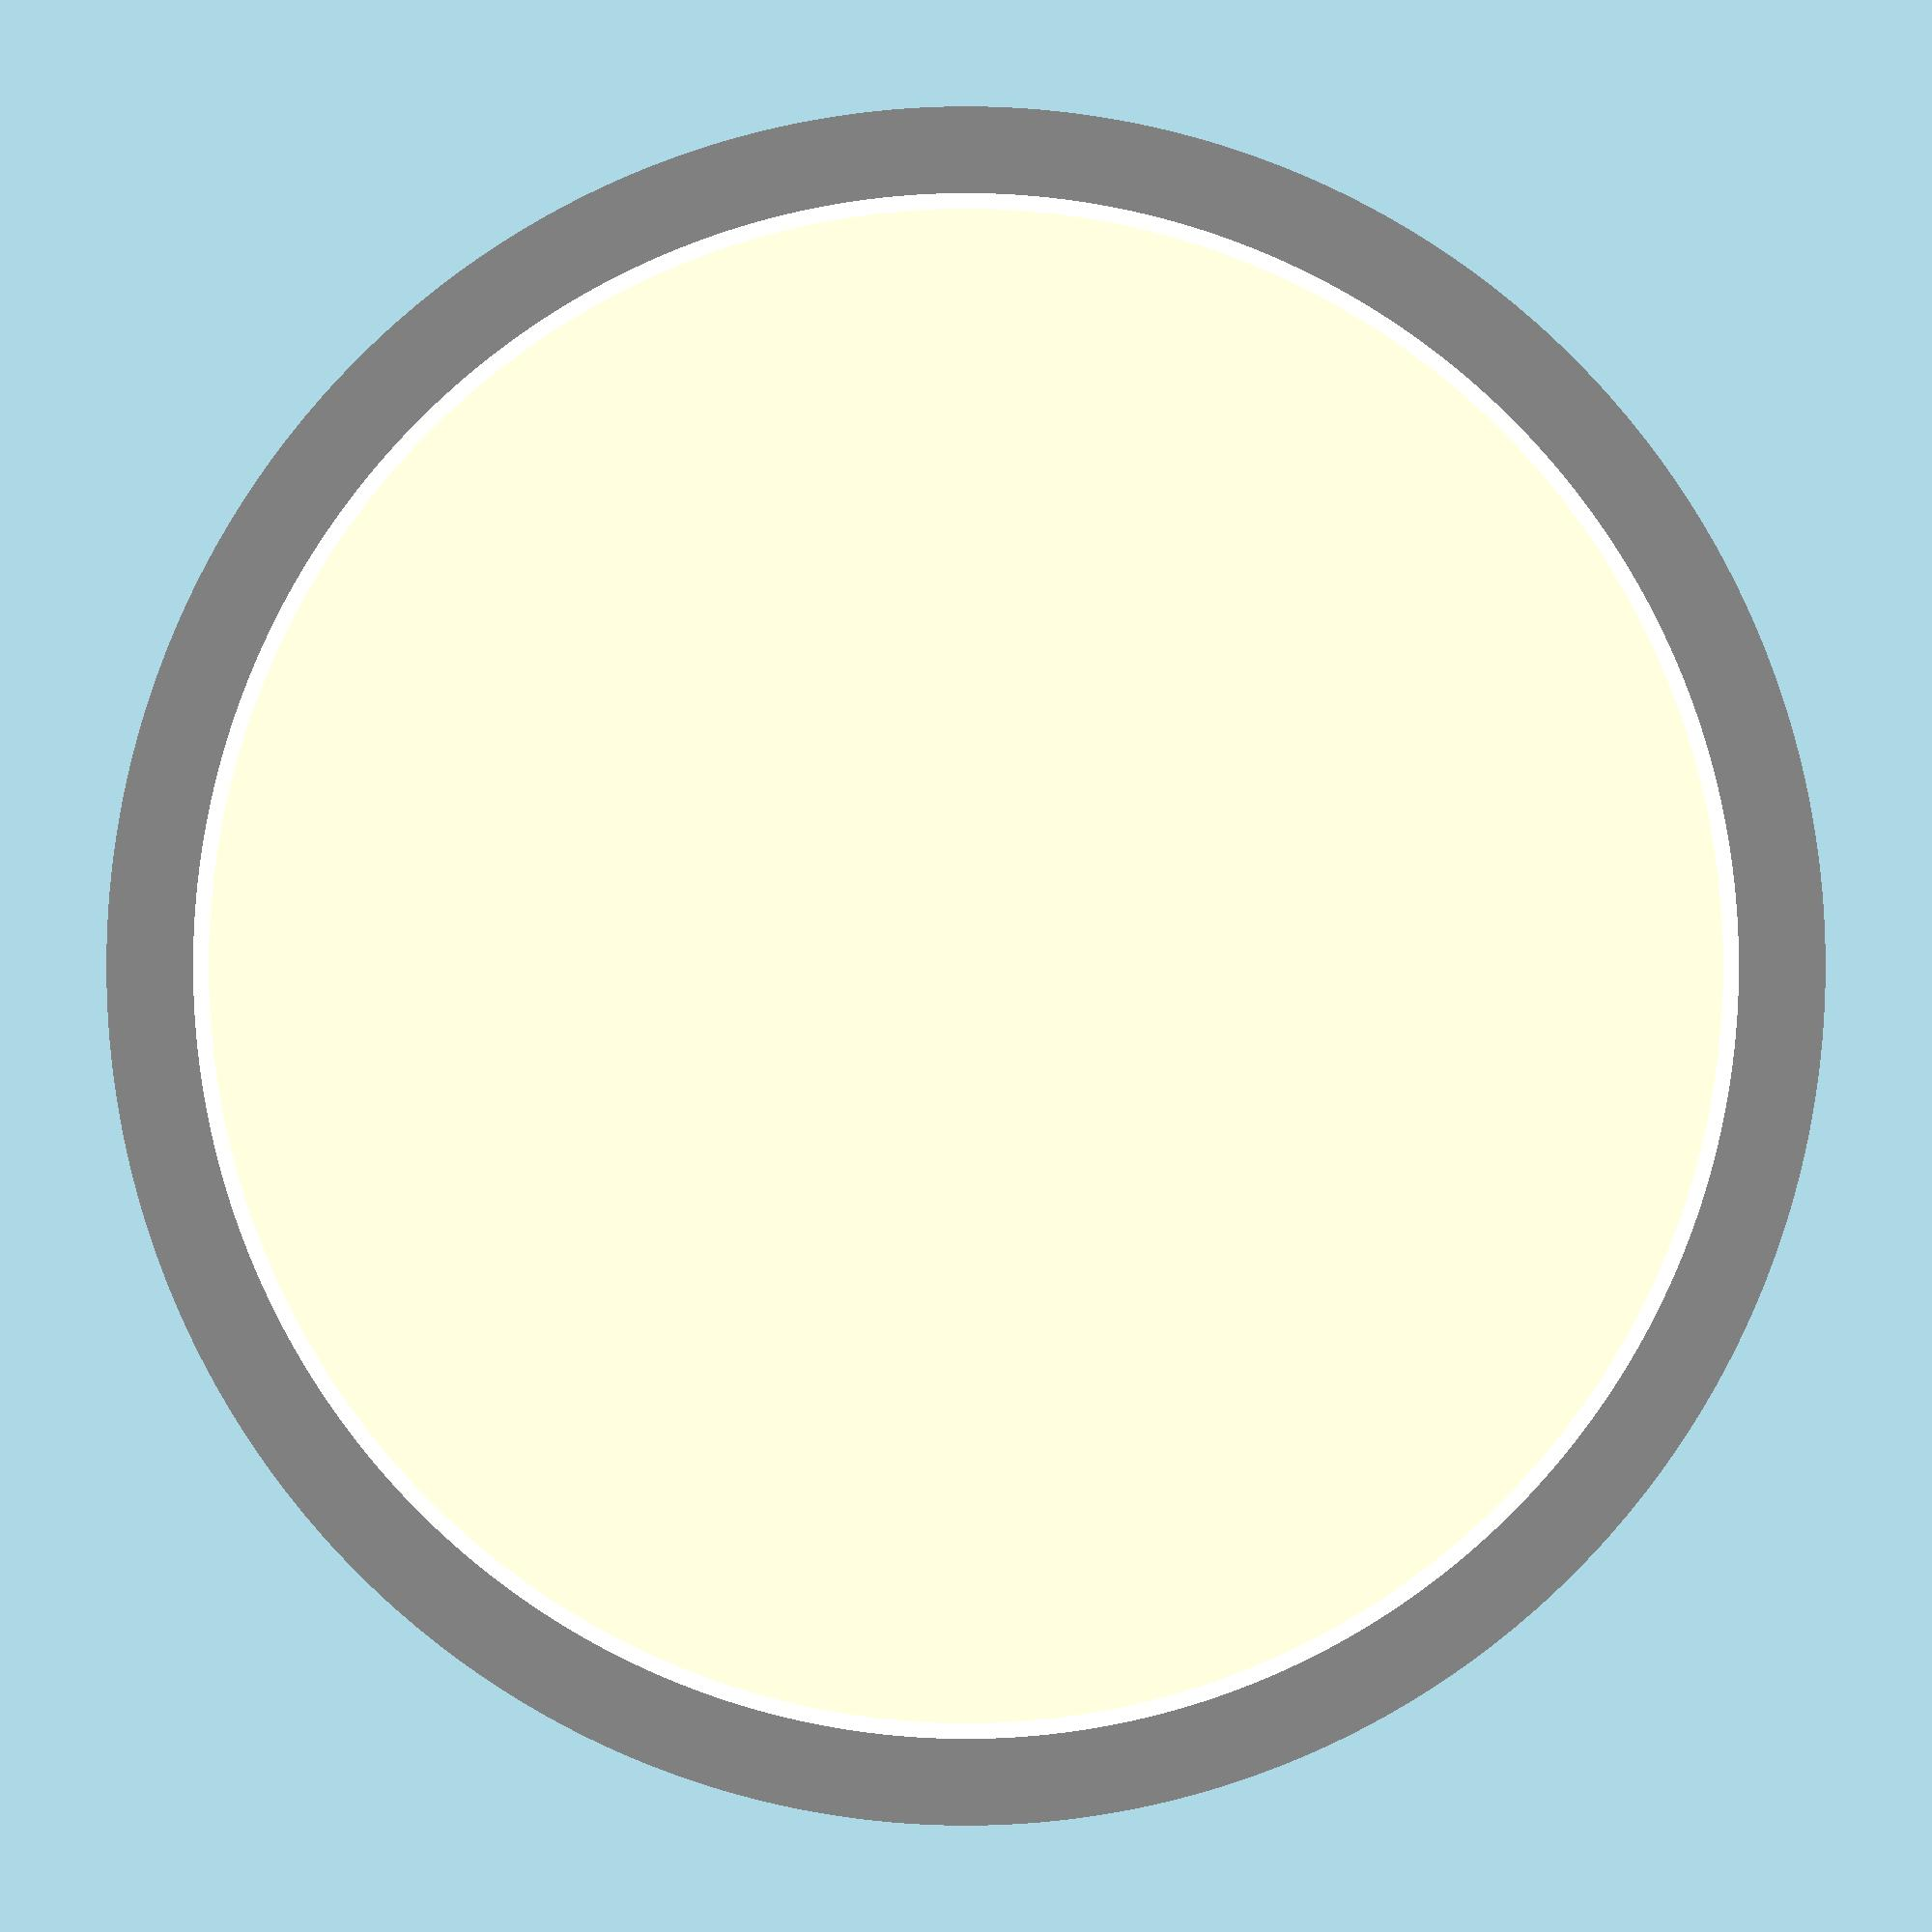

In [90]:
display(Image(filename=ruta + "/imagenes/pwr_fuelpin.jpg"))

## RUN

La ejecución de la simulación se realiza mediante __*openmc.run()*__

In [ ]:
# openmc.run()

In [ ]:
# cat tallies.out

Para comprobar la correcta definición de la geometría:

In [ ]:
# openmc.run(geometry_debug=True)

## DEPLETION

Para poder llevar a cabo la simulación del Depletion, es necesario proporcionar el volumen total de combustible.<br>
Este es un paso clave en la simulación ya que afecta directamente al quemado del combustible.

Se definen los volúmenes como el volumen de una varilla de combustible multiplicado por el total de varillas de un elemento y multiplicado por el número de elementos de cada tipo de enriquecimiento.

In [ ]:
vol_varillas_le = math.pi * (combustible_d/2) ** 2 * 366 * 28 * n_elementos_gadolinio_lbp28

In [ ]:
fuel_uo2_le.volume = math.pi * (combustible_d/2) ** 2 * 366 * 264 * 53 - vol_varillas_le

In [ ]:
vol_varillas_me = math.pi * (combustible_d/2) ** 2 * 366 * (88 * n_elementos_gadolinio_mbp88 + 44 * n_elementos_gadolinio_mbp44 + 28 * n_elementos_gadolinio_mbp28)

In [ ]:
fuel_uo2_me.volume = math.pi * (combustible_d/2) ** 2 * 366 * 264 * 52 - vol_varillas_me

In [ ]:
vol_varillas_he = math.pi * (combustible_d/2) ** 2 * 366 * (112 * n_elementos_gadolinio_hbp112 + 88 * n_elementos_gadolinio_hbp88 + 72 * n_elementos_gadolinio_hbp72)

In [ ]:
fuel_uo2_he.volume = math.pi * (combustible_d/2) ** 2 * 366 * 264 * 52 - vol_varillas_he

Volumen de las varillas de gadolinio y uranio

In [ ]:
fuel_uo2_lbp.volume = math.pi * (combustible_d/2) ** 2 * 366 * 28 * n_elementos_gadolinio_lbp28

In [ ]:
fuel_uo2_mbp.volume = math.pi * (combustible_d/2) ** 2 * 366 * (88 * n_elementos_gadolinio_mbp88 + 44 * n_elementos_gadolinio_mbp44 + 28 * n_elementos_gadolinio_mbp28)

In [ ]:
fuel_uo2_hbp.volume = math.pi * (combustible_d/2) ** 2 * 366 * (112 * n_elementos_gadolinio_hbp112 + 88 * n_elementos_gadolinio_hbp88 + 72 * n_elementos_gadolinio_hbp72)

La ejecución de la simulación se realiza mediante __*openmc.deplete*__

Es necesario aportar la cadena de desintegración, en este caso se usa la librería **ENDF/B-VII.1** para **espectro térmico**:

In [ ]:
chain = openmc.deplete.Chain.from_xml("./../../openmc/Cross_Section_Libraries/endfb71_hdf5/chain_endfb71_pwr.xml")

El primer paso es crear el *Operator* a partir de la geometría y la configuración (los materiales se leen automáticamente).

In [ ]:
model = openmc.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "./../../openmc/Cross_Section_Libraries/endfb71_hdf5/chain_endfb71_pwr.xml")

Se define el nombre de la carpeta en la que se almacenan los archivos generados durante la simulación

In [ ]:
operator.output_dir= ruta

Se define la potencia de la celda de combustible en *W*. Para un reactor de este tipo, se definen 1000 MWe

In [ ]:
power = 1000e6

Se definen los pasos de la simulación, en este caso se va a simular el reactor en pasos de 30 días y durante 4 años y medio (54 meses)

In [ ]:
n_pasos = 30

In [ ]:
n_repeticion_pasos = 54

In [ ]:
time_steps = [n_pasos] * n_repeticion_pasos

Se ejecuta la simulación:

In [ ]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [ ]:
# integrator = openmc.deplete.EPCRK4Integrator(operator, time_steps, power, timestep_units='d')

In [ ]:
integrator.integrate()

## RESULTADOS

### Importación de resultados desde archivo

Se importan los resultados desde el archivo creado.

In [ ]:
results = openmc.deplete.Results(ruta + "/depletion_results.h5")

Se obtiene la *k efectiva*.

In [ ]:
time, k = results.get_keff()

Se convierten las unidades de tiempo (de segundos a días).

In [ ]:
time /= (24 * 60 * 60)

### 1 - Resultados generales

Se representa la *k efectiva* en función del tiempo

In [ ]:
pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.ylim(0.9, 1.35)
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

In [ ]:
_, u235_fission1 = results.get_reaction_rate("1", "U235", "fission")
_, u235_fission2 = results.get_reaction_rate("2", "U235", "fission")
_, u235_fission3 = results.get_reaction_rate("3", "U235", "fission")
_, u235_fission6 = results.get_reaction_rate("6", "U235", "fission")
_, u235_fission7 = results.get_reaction_rate("7", "U235", "fission")

t_fission = u235_fission1 + u235_fission2 + u235_fission3 + u235_fission6 + u235_fission7

In [ ]:
pyplot.plot(time, t_fission)
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Total fisiones / s");

In [ ]:
pyplot.plot(time, u235_fission1, label="LE")
pyplot.plot(time, u235_fission2, label="ME")
pyplot.plot(time, u235_fission3, label="HE")
pyplot.plot(time, u235_fission6, label="ME Gd2O3")
pyplot.plot(time, u235_fission7, label="HE Gd2O3")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Fisiones / s")
pyplot.legend(loc="upper right")
pyplot.show()

In [ ]:
_, xe135_1 = results.get_atoms("1", "Xe135")
_, xe135_2 = results.get_atoms("2", "Xe135")
_, xe135_3 = results.get_atoms("3", "Xe135")
_, xe135_6 = results.get_atoms("6", "Xe135")
_, xe135_7 = results.get_atoms("7", "Xe135")
xe135 = xe135_1 + xe135_2 + xe135_3 + xe135_6 + xe135_7

In [ ]:
pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Número de átomos - Xe135");

---

### 2 - Masa restante de veneno consumible (Gadolinio)

In [ ]:
_, m_Gd152_1 = results.get_mass("1", "Gd152")
_, m_Gd152_2 = results.get_mass("2", "Gd152")
_, m_Gd152_3 = results.get_mass("3", "Gd152")
_, m_Gd152_6 = results.get_mass("6", "Gd152")
_, m_Gd152_7 = results.get_mass("7", "Gd152")

_, m_Gd154_1 = results.get_mass("1", "Gd154")
_, m_Gd154_2 = results.get_mass("2", "Gd154")
_, m_Gd154_3 = results.get_mass("3", "Gd154")
_, m_Gd154_6 = results.get_mass("6", "Gd154")
_, m_Gd154_7 = results.get_mass("7", "Gd154")

_, m_Gd155_1 = results.get_mass("1", "Gd155")
_, m_Gd155_2 = results.get_mass("2", "Gd155")
_, m_Gd155_3 = results.get_mass("3", "Gd155")
_, m_Gd155_6 = results.get_mass("6", "Gd155")
_, m_Gd155_7 = results.get_mass("7", "Gd155")

_, m_Gd156_1 = results.get_mass("1", "Gd156")
_, m_Gd156_2 = results.get_mass("2", "Gd156")
_, m_Gd156_3 = results.get_mass("3", "Gd156")
_, m_Gd156_6 = results.get_mass("6", "Gd156")
_, m_Gd156_7 = results.get_mass("7", "Gd156")

_, m_Gd157_1 = results.get_mass("1", "Gd157")
_, m_Gd157_2 = results.get_mass("2", "Gd157")
_, m_Gd157_3 = results.get_mass("3", "Gd157")
_, m_Gd157_6 = results.get_mass("6", "Gd157")
_, m_Gd157_7 = results.get_mass("7", "Gd157")

_, m_Gd158_1 = results.get_mass("1", "Gd158")
_, m_Gd158_2 = results.get_mass("2", "Gd158")
_, m_Gd158_3 = results.get_mass("3", "Gd158")
_, m_Gd158_6 = results.get_mass("6", "Gd158")
_, m_Gd158_7 = results.get_mass("7", "Gd158")

_, m_Gd160_1 = results.get_mass("1", "Gd160")
_, m_Gd160_2 = results.get_mass("2", "Gd160")
_, m_Gd160_3 = results.get_mass("3", "Gd160")
_, m_Gd160_6 = results.get_mass("6", "Gd160")
_, m_Gd160_7 = results.get_mass("7", "Gd160")


m_Gd_1 = m_Gd152_1 + m_Gd154_1 + m_Gd155_1 + m_Gd156_1 + m_Gd157_1 + m_Gd158_1 + m_Gd160_1
m_Gd_2 = m_Gd152_2 + m_Gd154_2 + m_Gd155_2 + m_Gd156_2 + m_Gd157_2 + m_Gd158_2 + m_Gd160_2
m_Gd_3 = m_Gd152_3 + m_Gd154_3 + m_Gd155_3 + m_Gd156_3 + m_Gd157_3 + m_Gd158_3 + m_Gd160_3
m_Gd_6 = m_Gd152_6 + m_Gd154_6 + m_Gd155_6 + m_Gd156_6 + m_Gd157_6 + m_Gd158_6 + m_Gd160_6
m_Gd_7 = m_Gd152_7 + m_Gd154_7 + m_Gd155_7 + m_Gd156_7 + m_Gd157_7 + m_Gd158_7 + m_Gd160_7

m_Gd_t = m_Gd_1 + m_Gd_2 + m_Gd_3 + m_Gd_6 + m_Gd_7

In [ ]:
pyplot.plot(time, m_Gd_1, label="LE")
pyplot.plot(time, m_Gd_2, label="ME")
pyplot.plot(time, m_Gd_3, label="HE")
pyplot.plot(time, m_Gd_6, label="ME Gd2O3")
pyplot.plot(time, m_Gd_7, label="HE Gd2O3")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Masa (g)");
pyplot.legend(loc="upper right")
pyplot.show()

### 3 - Resultados por nucleido

#### U235

Al tener varios tipos de combustible, es necesario obtener los datos para cada combustible por separado y sumarlos.<br>
En este caso, se realiza para el U235:

In [ ]:
# Se obtienen las masas de cada material (tipo de combustible) y se suman
_, m_u235_1 = results.get_mass("1", "U235")
_, m_u235_2 = results.get_mass("2", "U235")
_, m_u235_3 = results.get_mass("3", "U235")
_, m_u235_6 = results.get_mass("6", "U235")
_, m_u235_7 = results.get_mass("7", "U235")
m_u235 = m_u235_1 + m_u235_2 + m_u235_3 + m_u235_6 + m_u235_7

# Se calcula la producción de U235 en toneladas (en este caso, saldrá negativa ya que se consume)
p_u235 = (m_u235[n_repeticion_pasos] - m_u235[0])/1000000
p_u235 #ton

In [ ]:
m_u235[n_repeticion_pasos]/1000000 #ton

In [ ]:
# pyplot.plot(time, m_u235, label="Total")
pyplot.plot(time, m_u235_1/1000, label="LE")
pyplot.plot(time, m_u235_2/1000, label="ME")
pyplot.plot(time, m_u235_3/1000, label="HE")
pyplot.plot(time, m_u235_6/1000, label="ME Gd2O3")
pyplot.plot(time, m_u235_7/1000, label="HE Gd2O3")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg) - U235")
pyplot.legend(loc="upper right")
pyplot.show()

#### U238

In [ ]:
# Se obtienen las masas de cada material (tipo de combustible) y se suman
_, m_u238_1 = results.get_mass("1", "U238")
_, m_u238_2 = results.get_mass("2", "U238")
_, m_u238_3 = results.get_mass("3", "U238")
_, m_u238_6 = results.get_mass("6", "U238")
_, m_u238_7 = results.get_mass("7", "U238")
m_u238 = m_u238_1 + m_u238_2 + m_u238_3 + m_u238_6 + m_u238_7

# Se calcula la producción de U238 en toneladas (en este caso, saldrá negativa ya que se consume)
p_u238 = (m_u238[n_repeticion_pasos] - m_u238[0])/1000000
p_u238 #ton

In [ ]:
m_u238[n_repeticion_pasos]/1000000 #ton

In [ ]:
pyplot.plot(time, m_u238/1000, label="U238")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Masa (kg)");

#### Pu

In [ ]:
_, m_pu238_1 = results.get_mass("1", "Pu238")
_, m_pu238_2 = results.get_mass("2", "Pu238")
_, m_pu238_3 = results.get_mass("3", "Pu238")
_, m_pu238_6 = results.get_mass("6", "Pu238")
_, m_pu238_7 = results.get_mass("7", "Pu238")
m_pu238 = m_pu238_1 + m_pu238_2 + m_pu238_3 + m_pu238_6 + m_pu238_7
p_pu238 = (m_pu238[n_repeticion_pasos] - m_pu238[0])/1000
p_pu238 # kg

In [ ]:
_, m_pu239_1 = results.get_mass("1", "Pu239")
_, m_pu239_2 = results.get_mass("2", "Pu239")
_, m_pu239_3 = results.get_mass("3", "Pu239")
_, m_pu239_6 = results.get_mass("6", "Pu239")
_, m_pu239_7 = results.get_mass("7", "Pu239")
m_pu239 = m_pu239_1 + m_pu239_2 + m_pu239_3 + m_pu239_6 + m_pu239_7
p_pu239 = (m_pu239[n_repeticion_pasos] - m_pu239[0])/1000
p_pu239 # kg

In [ ]:
_, m_pu240_1 = results.get_mass("1", "Pu240")
_, m_pu240_2 = results.get_mass("2", "Pu240")
_, m_pu240_3 = results.get_mass("3", "Pu240")
_, m_pu240_6 = results.get_mass("6", "Pu240")
_, m_pu240_7 = results.get_mass("7", "Pu240")
m_pu240 = m_pu240_1 + m_pu240_2 + m_pu240_3 + m_pu240_6 + m_pu240_7
p_pu240 = (m_pu240[n_repeticion_pasos] - m_pu240[0])/1000
p_pu240 #kg

In [ ]:
_, m_pu241_1 = results.get_mass("1", "Pu241")
_, m_pu241_2 = results.get_mass("2", "Pu241")
_, m_pu241_3 = results.get_mass("3", "Pu241")
_, m_pu241_6 = results.get_mass("6", "Pu241")
_, m_pu241_7 = results.get_mass("7", "Pu241")
m_pu241 = m_pu241_1 + m_pu241_2 + m_pu241_3  + m_pu241_6 + m_pu241_7
p_pu241 = (m_pu241[n_repeticion_pasos] - m_pu241[0])/1000
p_pu241 #kg

In [ ]:
_, m_pu242_1 = results.get_mass("1", "Pu242")
_, m_pu242_2 = results.get_mass("2", "Pu242")
_, m_pu242_3 = results.get_mass("3", "Pu242")
_, m_pu242_6 = results.get_mass("6", "Pu242")
_, m_pu242_7 = results.get_mass("7", "Pu242")
m_pu242 = m_pu242_1 + m_pu242_2 + m_pu242_3 + m_pu242_6 + m_pu242_7
p_pu242 = (m_pu242[n_repeticion_pasos] - m_pu242[0])/1000
p_pu242 #kg

In [ ]:
pyplot.plot(time, m_pu238/1000, label="Pu238")
pyplot.plot(time, m_pu239/1000, label="Pu239")
pyplot.plot(time, m_pu240/1000, label="Pu240")
pyplot.plot(time, m_pu241/1000, label="Pu241")
pyplot.plot(time, m_pu242/1000, label="Pu242")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper left")
pyplot.show()

#### Np

In [ ]:
_, m_np237_1 = results.get_mass("1", "Np237")
_, m_np237_2 = results.get_mass("2", "Np237")
_, m_np237_3 = results.get_mass("3", "Np237")
_, m_np237_6 = results.get_mass("6", "Np237")
_, m_np237_7 = results.get_mass("7", "Np237")
m_np237 = m_np237_1 + m_np237_2 + m_np237_3 + m_np237_6 + m_np237_7
p_np237 = (m_np237[n_repeticion_pasos] - m_np237[0])/1000
p_np237 #kg

In [ ]:
m_np237[n_repeticion_pasos]

In [ ]:
pyplot.plot(time, m_np237/1000, label="Np237")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)");

#### Am

In [ ]:
_, m_am241_1 = results.get_mass("1", "Am241")
_, m_am241_2 = results.get_mass("2", "Am241")
_, m_am241_3 = results.get_mass("3", "Am241")
_, m_am241_6 = results.get_mass("6", "Am241")
_, m_am241_7 = results.get_mass("7", "Am241")
m_am241 = m_am241_1 + m_am241_2 + m_am241_3 + m_am241_6 + m_am241_7
p_am241 = (m_am241[n_repeticion_pasos] - m_am241[0])/1000
p_am241

In [ ]:
_, m_am243_1 = results.get_mass("1", "Am243")
_, m_am243_2 = results.get_mass("2", "Am243")
_, m_am243_3 = results.get_mass("3", "Am243")
_, m_am243_6 = results.get_mass("6", "Am243")
_, m_am243_7 = results.get_mass("7", "Am243")
m_am243 = m_am243_1 + m_am243_2 + m_am243_3 + m_am243_6 + m_am243_7
p_am243 = (m_am243[n_repeticion_pasos] - m_am243[0])/1000
p_am243

In [ ]:
pyplot.plot(time, m_am241/1000, label="Am241")
pyplot.plot(time, m_am243/1000, label="Am243")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper left")
pyplot.show()

#### Cm

In [ ]:
_, m_cm244_1 = results.get_mass("1", "Cm244")
_, m_cm244_2 = results.get_mass("2", "Cm244")
_, m_cm244_3 = results.get_mass("3", "Cm244")
_, m_cm244_6 = results.get_mass("6", "Cm244")
_, m_cm244_7 = results.get_mass("7", "Cm244")
m_cm244 = m_cm244_1 + m_cm244_2 + m_cm244_3 + m_cm244_6 + m_cm244_7
p_cm244 = m_cm244[n_repeticion_pasos] - m_cm244[0]
p_cm244

In [ ]:
_, m_cm245_1 = results.get_mass("1", "Cm245")
_, m_cm245_2 = results.get_mass("2", "Cm245")
_, m_cm245_3 = results.get_mass("3", "Cm245")
_, m_cm245_6 = results.get_mass("6", "Cm245")
_, m_cm245_7 = results.get_mass("7", "Cm245")
m_cm245 = m_cm245_1 + m_cm245_2 + m_cm245_3 + m_cm245_6 + m_cm245_7
p_cm245 = m_cm245[n_repeticion_pasos] - m_cm245[0]
p_cm245

In [ ]:
pyplot.plot(time, m_cm244, label="Cm244")
pyplot.plot(time, m_cm245, label="Cm245")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (g)")
pyplot.legend(loc="upper left")
pyplot.show()

---